In [4]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Individual phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper()

indi_estimators = [lr, rf, rufit_pcc]
indi_names = ['LR', 'RF', 'rufit_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [4]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

inter_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ',y.name)
    experiment = Experiment(indi_estimators, 
                        indi_names,
                        KFold(30, shuffle=True, random_state=STATE),
                        data.x, y.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 30 repetitions
******************************

Target:  vesicle
Running experiment with 30 repetitions
******************************

Target:  worm
Running experiment with 30 repetitions
******************************



In [10]:
# import pickle
# cur_save=open('./' + 'interpolation_30folder_indi' + '.p', 'rb')
# inter_no_comp = pickle.load(cur_save)

In [11]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
for key in inter_no_comp:
    df = inter_no_comp[key].summary()
    df['mean_train_error'] = 1- df['mean_train_accuracy']
    df['std_train_error'] = df['std_train_accuracy']
    df['mean_test_error'] = 1- df['mean_test_accuracy']
    df['std_test_error'] = df['std_test_accuracy']
    inter_no_comp[key] = df

In [22]:
# get base line 
# error
informed_error = []
for each in [data.sphere, data.vesicle, data.worm]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_error.append((1-max(prob)))
print('Informed error: ', informed_error)

uniformed_error = [0.5, 0.5, 0.5]
print('Uninformed error: ', uniformed_error)

Informed error:  [0.46283783783783783, 0.2922297297297297, 0.33783783783783783]
Uninformed error:  [0.5, 0.5, 0.5]


In [40]:
inter_no_comp[key] # name is wrong. Should be RuFit not Rufit pcc

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.537162,0.004921,0.537193,0.142011,-0.680825,0.001401,-0.685333,0.041018,0.462838,0.004921,0.462807,0.142011
RF,1.000000,0.000000,0.910789,0.079069,-0.059541,0.002032,-0.238839,0.142727,0.000000,0.000000,0.089211,0.079069
rufit_pcc,0.983690,0.004010,0.922456,0.049134,-0.077804,0.005103,-0.236979,0.147900,0.016310,0.004010,0.077544,0.049134


sphere 



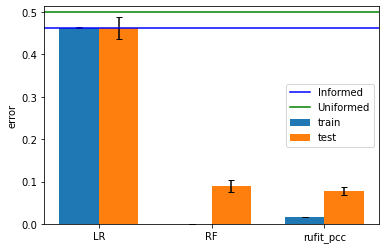

vesicle 



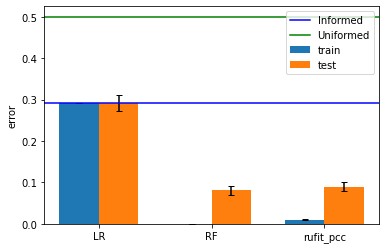

worm 



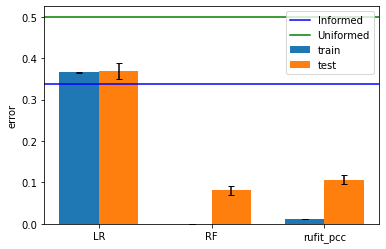

In [25]:
i = 0
for key in inter_no_comp:
    print(key, '\n')
    line = [informed_error[i], uniformed_error[i]]
    plot_summary('error', summ=inter_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

__Log likelihood__

All the estimators performs much better than random guessing and informed guessing.

In [43]:
# get base line 
# log loss
informed_loglikelihood = []
for each in [data.sphere, data.vesicle, data.worm]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_loglikelihood.append(sum(1*prob * np.log2(prob)))
print('Informed loglikelihood: ', informed_loglikelihood)

uniformed_loglikelihood = [1*0.5 * np.log2(0.5)*2] * 3
print('Uninformed loglikelihood: ', uniformed_loglikelihood)

Informed loglikelihood:  [-0.9960115235485287, -0.8715841441742509, -0.9227346209530941]
Uninformed loglikelihood:  [-1.0, -1.0, -1.0]


sphere 



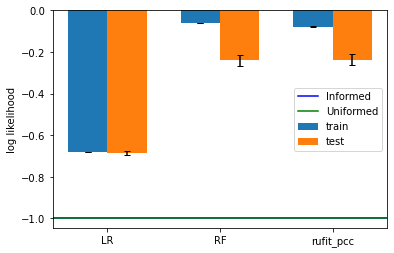

vesicle 



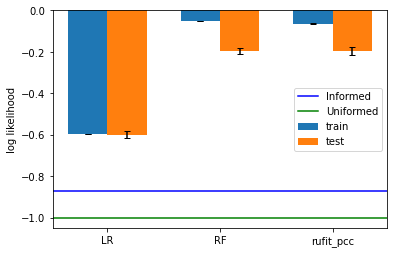

worm 



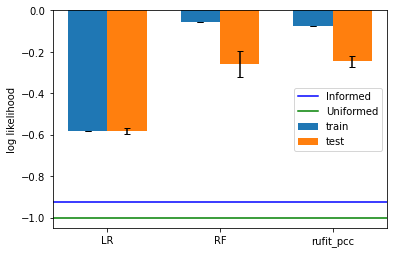

In [45]:
i = 0
for key in inter_no_comp:
    print(key, '\n')
    line = [informed_loglikelihood[i], uniformed_loglikelihood[i]]
    plot_summary('log likelihood', summ=inter_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()